<a href="https://colab.research.google.com/github/tuphr2234/ChaosPrediction/blob/main/ThreeBodySimulation_(3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Build Simulation

In [1]:
#pip install anvil-uplink

In [2]:
#import anvil.server

#anvil.server.connect("M2SHTQKH2FUIJQQXXX4VKXEB-I37SIP4DTE6Z5NM3")

In [3]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import tensorflow as tf
import os
from pathlib import Path  


G=1


class Body:
  
  prevPosition=np.array([0,0])
  position=np.array([0,0])
  velocity=np.array([0,0])
  force=np.array([0,0])
  acceleration=np.array([0,0])
  mass=0

  def __init__(self,position=[0,0],velocity=[0,0],mass=1,name="newBody"):
    self.position=np.array(position)
    self.velocity=np.array(velocity)
    #self.acceleration=np.array(acceleration)
    self.mass=mass
    self.prevPosition=np.array(position)
    self.name = name


  def setInitialPostion(self,position):
    self.postion = np.array(position)
    self.prevPosition=np.array(position)

    
  def setInitialVelocity(self,velocity):
    self.velocity = np.array(velocity)

   
  def setInitialMass(self,mass):
    self.mass = mass




  def setPosition(self,t):
    self.prevPosition = self.position
    self.position=self.position+self.velocity*t+(self.acceleration/2)* t**2
  

  def setVelocity(self,t):
    self.velocity=self.velocity+self.acceleration*t
  

  def getForce(self,body):
    softening = 0.01
    Distance = body.prevPosition - self.position
    Rsquare = Distance[0]**2 + Distance[1]**2 #+ softening
    #F = G* self.mass*body.mass / Rsquare  
    F = (G* self.mass*body.mass / Rsquare) - 0.001 / (Rsquare * Rsquare) ### Lennard-Jones like force
    normalizeDis = Distance / math.sqrt(Rsquare)
    F = F*normalizeDis
    if math.sqrt(Rsquare) < softening:
      F = -F 
    
    return F

  def setAcceleration(self,bodies):
    F=np.array([0,0])
    for body in bodies:
      F=F+self.getForce(body)
    self.acceleration = F/self.mass
   # print(f" {self.name} acceleration is {self.acceleration}")

In [4]:
def centerOfMass(vect):
  out =np.array([0,0])
  for i in range(0,len(vect),2):
    out = out + np.array(vect[i],vect[i+1])
  return out / (len(vect)//2) 

In [5]:
body = Body()

In [6]:

def simulateOnTimeStep(bodies,t,steps,interval_in_data): # bodies: list of bodies. t: timestep . steps: number of steps. interval_in_data : frequency of rows taken to dataset: if equals 1 than it is every step
  dataset = []

  for i in range(steps):
      list1=[]
      for body in bodies:
        list1.append(body.position)
      if i % interval_in_data ==0:
        dataset += list1
      
      for i,body in enumerate(bodies):
        body.setAcceleration([b for b in bodies if b is not body])
        body.setVelocity(t)
        body.setPosition(t)
       
        
      for body in bodies:
        body.prevPosition = body.position
    

  return np.array(dataset).reshape(steps//interval_in_data,len(bodies),2)



In [7]:
def numpyToPandas(simulation,numOfBodies):
  columns = []

  for i in range(numOfBodies):
    columns.append(f'Body{i+1} x')
    columns.append(f'Body{i+1} y')
  simulation_reshaped = simulation.reshape(len(simulation), numOfBodies*2 )

  df = pd.DataFrame(simulation_reshaped, columns = columns)
  return df


Add Filters

In [8]:
def addNoise(simulation):
  noise = np.random.normal(0, .1, simulation.shape)
  return simulation + noise
def removeBody(simulation, bodyNum):
  del1 = np.delete(simulation,(bodyNum-1)*2,1)
  return np.delete(del1,(bodyNum-1)*2,1)

Save Simulation

In [9]:
## save simulation as csv
def saveSimulation(simulation,numOfBodies,simulation_name):
  df = numpyToPandas(simulation,numOfBodies) 
  df.to_csv(f'/content/{simulation_name}.csv',index=False)
  
def loadSimulation(df):
  return pd.DataFrame.to_numpy(df)  

Prepare Dataset 

In [10]:
def prepareData(simulation,window_size_X,window_size_y): 
  X = []
  y = []
  for i in range(len(simulation)-window_size_X - window_size_y):
    row = [bodies for bodies in simulation[i:i+window_size_X]]  
    X.append(row)
    label =  [bodies for bodies in simulation[i+window_size_X:i+window_size_X + window_size_y]]#######################################
    y.append(label)

  return np.array(X) , np.array(y)


In [11]:
def createRandomTrainingSetForPreTrainedModel():
    randomSimulations = []
    numOfSimulations = 20
    X_trainArr = [None]*numOfSimulations
    y_trainArr = [None]*numOfSimulations
    for i in range(numOfSimulations):
      randomSimulations.append(createRandomSimulation(4,timestep,steps,interval_in_data))
      X_trainArr[i], y_trainArr[i] = prepareData(train,windowSizeX,windowSizeY)

    for i in range(len(randomSimulations)):
      saveSimulation(randomSimulations[i],numOfBodies,f"{numOfBodies}-Body Simulation{i+20}")


    return X_trainArr, y_trainArr

In [12]:

def trainOnRandomSimulations(epochs, numOfSimulations, X_trainArr,y_trainArr):

    for i in range(epochs):
      for j in range(numOfSimulations):
      #model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=2, callbacks=[cp1])
      #history = model.fit(X_train, y_train, epochs=1, callbacks=[cp1])
        history = model.fit(X_trainArr[i], y_trainArr[i], epochs=1, callbacks=[cp1])
        

In [13]:
def splitToTrainValidTest(dataset,testPercentage):
  trainLen = round((len(dataset)*(1-testPercentage-0.05)))
  valLen = round((len(dataset)*0.05))
  train_set = dataset[:trainLen]
  val_set = dataset[trainLen:trainLen+valLen]
  test_set = dataset[trainLen+valLen:]
  return train_set,val_set,test_set

In [14]:
def drawSimulation(simulation):
  prev = np.copy(simulation[0])
  numOfBodies = len(simulation[0])
  colors = ['red','green','blue','yellow','black']
  for i,sim in enumerate(simulation):
    if i == 0:
      continue
    for j in range(0,len(sim),2):
      plt.plot([prev[j],sim[j]],[prev[j+1],sim[j+1]],  color = colors[j // 2])
      prev[j] = np.copy(sim[j])
      prev[j+1] = np.copy(sim[j+1])
  plt.show()


In [15]:
def showBodiesMovmentInGraph(simulation):
  plt.title("X body coordinate")
  for i in range(0,len(simulation.columns),2):
      df = simulation.iloc[:,i]
      plt.plot(df)
  plt.show()
  plt.title("Y body coordinate")
  for i in range(1,len(simulation.columns),2):
      df = simulation.iloc[:,i]
      plt.plot(df)
  plt.show()




Preprocessing/Postprocessing

Model

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

def buildModelCNN(window_size_X,window_size_y,numberOfBodies): 
  model = Sequential()
 # model.add(InputLayer((window_size_X,numberOfBodies*2)))


  model.add(tf.keras.layers.Conv2D(32, (3,3), padding="same", activation="relu", input_shape=(window_size_X, numberOfBodies*2, 1)))
  model.add(tf.keras.layers.Conv2D(32, (3,3), padding="same", activation="relu", input_shape=(window_size_y, numberOfBodies*2, 1)))

  #model.add(Conv1D(64, kernel_size=2)) ###
  #model.add(Dropout(0.2))
 # model.add(Conv1D(32, kernel_size=(3,3))) ###
  model.add(Flatten())
  #model.add(LSTM(32))
  #model.add(Dropout(0.2))
  #model.add(Dense(16, 'relu'))
  model.add(Dense(units =  window_size_y*numberOfBodies*2, activation ='linear'))
  model.add(tf.keras.layers.Reshape([window_size_y, numberOfBodies*2]))
  model.summary()
  return model

In [17]:
def slidingWindowActualPredictions(model,windowArr,windowSize,NumOfBodies,predictionsRequestedNumber): ### One step at a time autoregression
  

  actualPredictionArr =[]
  for i in range(predictionsRequestedNumber):

    prediction = model.predict(windowArr[-1:]) ### predict from last window
    actualPredictionArr.append(prediction)
    temp = np.zeros([windowSize,numOfBodies*2])
    temp = temp + windowArr[-1]
    temp =temp[1:]
    newWindow = np.append(temp.reshape(windowSize-1,numOfBodies*2),prediction)
    newWindow = newWindow.reshape(windowSize,numOfBodies*2)
    lengthX = len(windowArr)
    windowArr = np.append(windowArr,newWindow) ### add new window that the last vector is the prediction 
    windowArr = windowArr.reshape(lengthX+1,windowSize,numOfBodies*2)

  return actualPredictionArr

In [18]:
def preprocessSimulation(simulation):
  shape = simulation[0].shape
  newSimulation = np.append(simulation[1:],[np.zeros(shape)],axis=0) - simulation
  newSimulation = newSimulation[:-1]
  for i,s in enumerate(newSimulation):
    s = s / np.linalg.norm(simulation[i])
  return newSimulation

In [19]:
def postprocess(lastKnownElement , listOfPredictedChanges):
  listOfPredictions = []
  for pred in listOfPredictedChanges:
    #newElement = (pred * np.linalg.norm(lastKnownElement)) + lastKnownElement
    newElement = pred  + lastKnownElement
    listOfPredictions.append(newElement)
    lastKnownElement = newElement
  return np.array(listOfPredictions)  


In [20]:
def createRandomSimulation(numOfBodies,timestep,steps,interval_in_data):
  bodies =[]
  for i in range(numOfBodies):
    bodies.append( Body( np.array([np.random.uniform(-1,1),np.random.uniform(-1,1)]), np.array([np.random.uniform(-1,1) , np.random.uniform(-1,1)]) , 1 ) )

  simulation = simulateOnTimeStep(bodies,timestep,steps,interval_in_data)
  simulation=simulation1.reshape(len(simulation), numOfBodies*2 )
  return simulation   

Training Model

In [ ]:
#Body(position,velocity,mass,name)
#%%timeit
bodies=[]


bodies.append(Body([0.97000436,-0.24308753],[0,0],1,"body1"))
bodies.append(Body([-0.97000436,0.24308753],[0,0],1,"body2"))
bodies.append(Body([0, 0],[-0,-0],1,"body3"))
bodies.append(Body([0.3, 0.24308753],[0, 0],1,"body4"))




##########################################

# The 8 Figure motion initials

#bodies.append(Body([-0.97000436, 0.24308753],[0.4662036850, 0.4323657300],1,"body1"))
#bodies.append(Body([0.97000436, -0.24308753],[0.4662036850, 0.4323657300],1,"body2"))
#bodies.append(Body([0, 0],[-0.93240737, -0.86473146],1,"body3"))

##########################################



numOfBodies=len(bodies)
##t: timestep . steps: number of steps. interval_in_data
timestep = 0.0001 # actual seconds
steps = 1220000
#steps = 3000000
interval_in_data = 500

simulation1 = simulateOnTimeStep(bodies,timestep,steps,interval_in_data)
simulation1=simulation1.reshape(len(simulation1), numOfBodies*2 )
saveSimulation(simulation1,numOfBodies,f"{numOfBodies}-Body Simulation")
drawSimulation(simulation1)

In [ ]:
#randSim = createRandomSimulation(4,timestep,steps,interval_in_data)

In [ ]:
#simulation1 = simulation1[:,2:8]
simulation1 = simulation1[100:]

simulation1.shape

In [ ]:
#drawSimulation(simulation1[50:2000])

In [ ]:
numOfBodies = simulation1.shape[1] // 2

In [ ]:
#drawSimulation(simulation1[50:2000])

In [ ]:
#simulation1 = simulation1[100:]

In [ ]:
showBodiesMovmentInGraph(numpyToPandas(simulation1,numOfBodies))

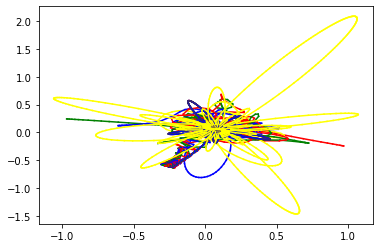

In [24]:
simulation1 = loadSimulation(pd.read_csv(f'/content/{numOfBodies}-Body Simulation.csv'))
drawSimulation(simulation1)

In [26]:
#from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from scipy.signal import hilbert
scaled = False 

batch = 128

diffSimulation1 = np.diff(simulation1[:700],axis = 0)
#diffSimulation1 = preprocessSimulation(simulation1)
#diffSimulation1 = np.diff(simulation1[:,2:8],axis = 0)
train, val, test = splitToTrainValidTest(diffSimulation1,0.05)


windowSizeX=100#len(test)
windowSizeY =100#len(test)


if scaled:
  scaler = StandardScaler()
  scaler.fit(simulation1[:len(train)+len(val)])
  #valScaler.fit(train)  ### train / val as input ? 

  train = scaler.transform(train)
  val = scaler.transform(val)
  #train = hilbert(train)
  #val = hilbert(val)

X_train, y_train = prepareData(train,windowSizeX,windowSizeY)
X_val, y_val = prepareData(val,windowSizeX,windowSizeY)
X_test, y_test = prepareData(test,windowSizeX,windowSizeY)


model =  buildModelCNN(windowSizeX,windowSizeY,numOfBodies)
cp1 = ModelCheckpoint('model/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])




#generator = TimeseriesGenerator(train_scaled,train_scaled,length = len(test),batch_size=batch)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 8, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 8, 32)        9248      
                                                                 
 flatten (Flatten)           (None, 25600)             0         
                                                                 
 dense (Dense)               (None, 800)               20480800  
                                                                 
 reshape (Reshape)           (None, 100, 8)            0         
                                                                 
Total params: 20,490,368
Trainable params: 20,490,368
Non-trainable params: 0
_________________________________________________________________


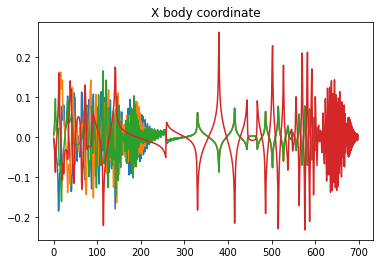

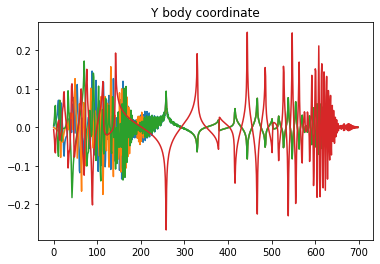

In [27]:
showBodiesMovmentInGraph(numpyToPandas(diffSimulation1,numOfBodies))

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=15, callbacks=[cp1])

In [ ]:
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
#plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
#history = model.fit_generator(generator,epochs=100,verbose=1)

Predictions

In [30]:
from sklearn.metrics import mean_squared_error

In [ ]:
#predictions = model.predict(X_test)          ###############  LOCAL RMSE  (prediction per window on test set)
#predictions = postprocess(val[-1],predictions)
#predictions = scaler.inverse_transform(predictions)
#print(math.sqrt(mean_squared_error(y_test,predictions)))
#print(math.sqrt(mean_squared_error(y_test.reshape(len(X_test),windowSizeY*numOfBodies*2),predictions.reshape(len(X_test),windowSizeY*numOfBodies*2))))


In [46]:
predictions = model.predict(X_train[-1:])
predictions=predictions.squeeze()

# One-shot prediction : 
actualPredictions = postprocess(simulation1[len(X_train)+windowSizeX-1],predictions)
##### ACTUAL RMSE #####
print(math.sqrt(mean_squared_error(postprocess(simulation1[len(X_train)-1],diffSimulation1[len(X_train):len(X_train)+windowSizeY]),actualPredictions)))


0.24631565464589367


In [ ]:
#######  Autoregressive prediction - Only in case Y window is in size 1 ######
import math

if windowSizeY == 1:

    AutoregressivePredictions = slidingWindowActualPredictions(model,X_train,windowSizeX,numOfBodies,len(test))
    AutoregressivePredictions =np.array(AutoregressivePredictions)
    AutoregressivePredictions = AutoregressivePredictions.squeeze()

    actualPredictions = postprocess(simulation1[len(X_train)+len(test)-1],AutoregressivePredictions)

    if scaled:
      actualPredictions = scaler.inverse_transform(actualPredictions)
  ##### ACTUAL RMSE #####
    print(math.sqrt(mean_squared_error(postprocess(simulation1[len(X_train)-1],diffSimulation1[len(X_train):len(X_train)+windowSizeY]),actualPredictions)))

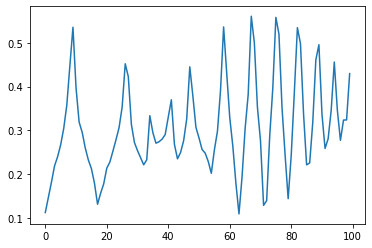

In [40]:
### Distance at each point throught the prediction
import matplotlib.pyplot as plt
disArr = []
#for i in range(len(val)+len(test)):
  #disArr.append(np.linalg.norm(simulation1[len(X_train)+windowSizeX+i+1]-listOfPredictionsTrue[i]))
for i in range(windowSizeY):
  disArr.append(np.linalg.norm(postprocess(simulation1[len(X_train)+windowSizeX-1],diffSimulation1[len(X_train)+windowSizeX:len(X_train)+windowSizeX+windowSizeY])[i]-actualPredictions[i]))

plt.plot(disArr)  

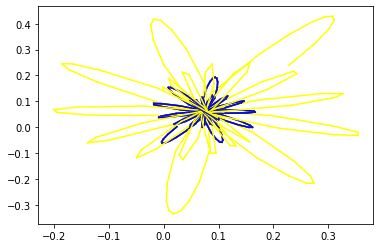

In [35]:
#drawSimulation(simulation1[len(X_train)+windowSizeX+2:len(X_train)+windowSizeX+31])
drawSimulation(simulation1[len(X_train)+ windowSizeX: len(X_train) + windowSizeX + windowSizeY ])

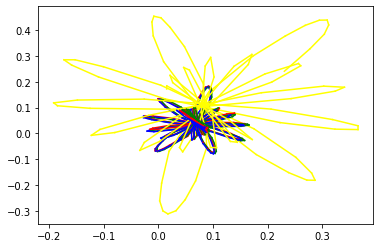

In [47]:
#drawSimulation(listOfPredictionsTrue[1:30])
drawSimulation(actualPredictions)